# Predicting NBA All-Stars

## Motivation

The National Basketball Association (NBA) is a professional basketball league in North America, currently composed of 30 teams (29 in the US and 1 in Canada). It is the best basketball league in the world attracting the best players from around the world. Every year, around the midpoint of the season in February, they organize an exhibition game called the All-Star game. 24 of the best players in the league are chosen as the All-Stars to play in this game as voted by fans, media, fellow players and coaches. 

Being an all-star is regarded as a great achievement and therefore has been used as a metric in ranking the players historically. Usually team success and player performance are used by the voters in their selections. The goal of this study is to gather pre-all-star break data from the official NBA stats website to see if we can develop a machine learning model that can predict this year's all-stars based on per game stats.   

## NBA All-Star Selection Process

The All-Star Selection process is best summarized in the Wikipedia article: 

https://en.wikipedia.org/wiki/NBA_All-Star_Game

"... The starting lineup for each squad is selected by a combination of fan, player, and media voting, while head coaches choose the reserves, seven players from their respective conferences, so each side has a 12-man roster... If a selected player cannot participate because of injury, the NBA commissioner selects a replacement... 

... The starting five from each conference consists of three frontcourt players and two guards, selected by a combination of fan, player, and media voting. In 2017, the NBA moved from a pure fan vote to a weighted process wherein fan voting accounts for 50%, with player and media voting account for 25% each. Prior to 2013, fans selected two forwards and one center instead of generic frontcourt players ...

... NBA coaches vote for the reserves for their respective conferences, but they cannot choose players from their own team. Each coach selects two guards, three frontcourt players and two wild cards, with each selected player ranked in order of preference within each category ..."

Based on these selection rules, it is clear that we need information on the positions and conferences in addition to player performance and team stats.

## Data Collection

The required data was collected using 2 different web scraping techniques from the official NBA Stats and the RealGM websites. The explanation and the codes can be found in the notebook "nba_stats_scraping.ipynb" which is located in the same repository:

github.com/ibraeksi/nba-analytics/nba_stats_scraping.ipynb

The pre all-star break stats are only available starting from the 1996-97 season. So we have the following data from the past 25 years to work with:

In [1]:
# Importing libraries
import os, sys
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

# Configure libraries
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

# Add base to path
sys.path.append('..')
sys.path.append('../../')

# Initialize dirs
data_dir = 'data'
input_data_dir = os.path.join(data_dir, 'input')
output_data_dir = os.path.join(data_dir, 'output')

In [2]:
pl = pd.read_csv(os.path.join(input_data_dir, 'pre_allstar_player_stats.csv'))
tm = pd.read_csv(os.path.join(input_data_dir, 'pre_allstar_team_stats.csv'))
allstar = pd.read_csv(os.path.join(input_data_dir, 'allstar_selection.csv'))
bio = pd.read_csv(os.path.join(input_data_dir, 'player_bio_historical.csv'))

The data dictionary:

    GP   :  Games Played
    W    :  Wins
    L    :  Losses
    MIN  :  Minutes Played
    FGM  :  Field Goals Made
    FGA  :  Field Goals Attempted
    FG%  :  Field Goal Percentage
    3PM  :  3 Point Field Goals Made
    3PA  :  3 Point Field Goals Attempted
    3P%  :  3 Point Field Goals Percentage
    FTM  :  Free Throws Made
    FTA  :  Free Throws Attempted
    FT%  :  Free Throw Percentage
    OREB :  Offensive Rebounds
    DREB :  Defensive Rebounds
    REB  :  Rebounds
    AST  :  Assists
    TOV  :  Turnovers
    STL  :  Steals
    BLK  :  Blocks
    PF   :  Personal Fouls
    DD2  :  Double doubles
    TD3  :  Triple doubles
    PTS  :  Points
    +/-  :  Plus Minus
    FP   :  Fantasy Points calculated with the formula Pts: 1 Rebs: 1.2 Ast: 1.5 Stl: 3 Blocks: 3 TO: -1
    _RANK:  NBA Rank in above stats

Looking at the player dataframe, we can see that we have 5 rows with missing names or team information.

In [3]:
pl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12817 entries, 0 to 12816
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PLAYER_ID              12817 non-null  int64  
 1   PLAYER_NAME            12817 non-null  object 
 2   NICKNAME               12817 non-null  object 
 3   TEAM_ID                12817 non-null  int64  
 4   TEAM_ABBREVIATION      12817 non-null  object 
 5   AGE                    12817 non-null  float64
 6   GP                     12817 non-null  int64  
 7   W                      12817 non-null  int64  
 8   L                      12817 non-null  int64  
 9   W_PCT                  12817 non-null  float64
 10  MIN                    12817 non-null  float64
 11  FGM                    12817 non-null  float64
 12  FGA                    12817 non-null  float64
 13  FG_PCT                 12817 non-null  float64
 14  FG3M                   12817 non-null  float64
 15  FG

In [5]:
pl.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON
0,920,A.C. Green,A.C.,1610612742,DAL,33.0000,45,15,30,0.3330,22.8000,2.2000,4.9000,0.4570,0.0000,0.1000,0.1670,1.2000,1.9000,0.5980,1.8000,4.1000,5.9000,0.8000,0.7000,0.6000,0.1000,0.6000,1.4000,0.0000,5.6000,-3.8000,15.1000,2,0,13.6000,95,208,33,314,178,219,235,149,270,276,260,208,177,336,77,72,72,261,313,223,341,111,317,48,225,371,198,103,13,209,1996-97
1,243,Aaron McKie,Aaron,1610612765,DET,24.0000,47,28,19,0.5960,18.9000,1.4000,3.9000,0.3570,0.5000,1.2000,0.4140,1.1000,1.3000,0.8390,0.4000,1.9000,2.3000,2.0000,1.1000,0.9000,0.4000,0.4000,1.6000,0.0000,4.4000,0.4000,12.8000,0,0,11.7000,27,65,163,140,221,296,271,367,150,170,55,214,235,60,338,221,256,129,229,130,163,194,280,135,275,150,229,176,13,240,1996-97
2,1425,Aaron Williams,Aaron,1610612763,VAN,25.0000,4,0,4,0.0000,9.7000,1.5000,2.8000,0.5450,0.0000,0.0000,0.0000,1.5000,2.5000,0.6000,1.3000,2.8000,4.0000,0.3000,1.3000,0.3000,1.3000,0.0000,1.5000,0.0000,4.5000,-1.0000,12.9000,0,0,11.8000,402,415,361,415,346,285,323,22,278,335,278,166,135,329,152,141,139,377,190,335,34,394,292,135,267,233,225,176,13,238,1996-97
3,768,Acie Earl,Acie,1610612749,MIL,27.0000,36,11,25,0.3060,12.4000,1.5000,4.1000,0.3690,0.0000,0.1000,0.0000,1.2000,1.9000,0.6470,0.9000,1.4000,2.3000,0.5000,0.9000,0.3000,0.7000,0.2000,1.5000,0.0000,4.3000,-1.6000,10.0000,0,0,9.1000,214,267,77,333,303,283,265,355,278,275,278,201,184,301,207,267,253,318,267,308,79,334,292,135,280,275,277,176,13,282,1996-97
4,228,Adam Keefe,Adam,1610612762,UTA,27.0000,43,30,13,0.6980,14.6000,1.3000,2.5000,0.5190,0.0000,0.0000,0.0000,1.0000,1.4000,0.6610,1.3000,2.3000,3.6000,0.6000,0.7000,0.5000,0.2000,0.2000,1.6000,0.0000,3.6000,1.7000,10.2000,1,0,9.2000,141,54,237,90,266,305,340,39,278,335,278,236,224,282,147,178,163,293,307,242,257,295,275,93,307,98,274,129,13,281,1996-97


In [6]:
tm.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,SEASON
0,1610612737,Atlanta Hawks,46,31,15,0.6740,48.4000,33.8000,77.0000,0.4380,7.9000,21.9000,0.3600,17.7000,23.3000,0.7600,12.5000,29.5000,42.0000,17.8000,14.7000,7.6000,5.4000,4.1000,19.3000,0.1000,93.2000,5.1000,18,9,7,8,12,27,21,23,1,1,13,20,25,4,14,10,10,29,3,23,9,4,1,27,25,5,1996-97
1,1610612738,Boston Celtics,46,11,35,0.2390,48.7000,37.7000,85.1000,0.4430,4.8000,13.8000,0.3490,18.9000,25.3000,0.7470,13.3000,27.1000,40.4000,21.3000,16.7000,10.3000,4.2000,6.7000,23.4000,0.2000,99.2000,-5.3000,18,27,28,28,4,3,2,20,23,23,19,12,13,10,8,25,20,17,21,2,23,29,22,15,7,24,1996-97
2,1610612766,Charlotte Hornets,48,29,19,0.6040,48.2000,35.4000,77.3000,0.4590,7.0000,16.4000,0.4240,18.4000,24.1000,0.7630,11.2000,28.0000,39.1000,23.9000,14.8000,7.0000,3.9000,4.6000,21.3000,0.2000,96.2000,-0.1000,3,10,10,10,25,16,20,9,8,16,1,15,21,3,28,19,25,4,5,26,26,9,8,8,13,14,1996-97
3,1610612741,Chicago Bulls,48,42,6,0.8750,48.1000,39.8000,84.4000,0.4710,6.3000,17.3000,0.3610,16.5000,22.3000,0.7430,14.6000,29.6000,44.3000,25.4000,13.1000,8.8000,3.8000,3.5000,19.5000,0.1000,102.3000,11.8000,3,1,1,1,29,1,3,2,12,12,12,26,27,11,3,7,3,2,1,6,27,2,2,22,1,1,1996-97
4,1610612739,Cleveland Cavaliers,47,25,22,0.5320,48.4000,33.6000,73.7000,0.4550,6.3000,16.0000,0.3930,14.8000,20.6000,0.7180,11.4000,26.7000,38.1000,21.3000,14.8000,8.4000,4.3000,4.6000,23.3000,0.3000,88.1000,3.4000,13,11,12,12,17,28,29,14,11,17,3,28,28,22,26,27,29,16,4,12,21,8,21,3,29,9,1996-97


In [7]:
bio.head()

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,JERSEY_NUMBER,POSITION,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
0,76001,Abdelnaby,Alaa,alaa-abdelnaby,1610612757,blazers,0,Portland,Trail Blazers,POR,30,F,6-10,240.0000,Duke,USA,1990.0000,1.0000,25.0000,NaN,5.7000,3.3000,0.3000,Career,1990,1994
1,76002,Abdul-Aziz,Zaid,zaid-abdul-aziz,1610612745,rockets,0,Houston,Rockets,HOU,54,C,6-9,235.0000,Iowa State,USA,1968.0000,1.0000,5.0000,NaN,9.0000,8.0000,1.2000,Career,1968,1977
2,76003,Abdul-Jabbar,Kareem,kareem-abdul-jabbar,1610612747,lakers,0,Los Angeles,Lakers,LAL,33,C,7-2,225.0000,UCLA,USA,1969.0000,1.0000,1.0000,NaN,24.6000,11.2000,3.6000,Career,1969,1988
3,51,Abdul-Rauf,Mahmoud,mahmoud-abdul-rauf,1610612743,nuggets,0,Denver,Nuggets,DEN,1,G,6-1,162.0000,Louisiana State,USA,1990.0000,1.0000,3.0000,NaN,14.6000,1.9000,3.5000,Career,1990,2000
4,1505,Abdul-Wahad,Tariq,tariq-abdul-wahad,1610612758,kings,0,Sacramento,Kings,SAC,9,F-G,6-6,235.0000,San Jose State,France,1997.0000,1.0000,11.0000,NaN,7.8000,3.3000,1.1000,Career,1997,2003


As seen, we have a unique PLAYER_ID which is the same as PERSON_ID in bio dataframe that we can use to add the required columns to the player dataframe: 

In [8]:
pl['POS'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['POSITION'])
pl['HT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['HEIGHT'])
pl['WT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['WEIGHT'])
pl['COLLEGE'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['COLLEGE'])
pl['COUNTRY'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['COUNTRY'])
pl['DRAFT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_YEAR'])
pl['ROUND'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_ROUND'])
pl['PICK'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_NUMBER'])
pl['DEBUT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['FROM_YEAR'])

In [9]:
pl.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT
0,920,A.C. Green,A.C.,1610612742,DAL,33.0000,45,15,30,0.3330,22.8000,2.2000,4.9000,0.4570,0.0000,0.1000,0.1670,1.2000,1.9000,0.5980,1.8000,4.1000,5.9000,0.8000,0.7000,0.6000,0.1000,0.6000,1.4000,0.0000,5.6000,-3.8000,15.1000,2,0,13.6000,95,208,33,314,178,219,235,149,270,276,260,208,177,336,77,72,72,261,313,223,341,111,317,48,225,371,198,103,13,209,1996-97,F,6-9,225.0000,Oregon State,USA,1985.0000,1.0000,23.0000,1985
1,243,Aaron McKie,Aaron,1610612765,DET,24.0000,47,28,19,0.5960,18.9000,1.4000,3.9000,0.3570,0.5000,1.2000,0.4140,1.1000,1.3000,0.8390,0.4000,1.9000,2.3000,2.0000,1.1000,0.9000,0.4000,0.4000,1.6000,0.0000,4.4000,0.4000,12.8000,0,0,11.7000,27,65,163,140,221,296,271,367,150,170,55,214,235,60,338,221,256,129,229,130,163,194,280,135,275,150,229,176,13,240,1996-97,G,6-5,209.0000,Temple,USA,1994.0000,1.0000,17.0000,1994
2,1425,Aaron Williams,Aaron,1610612763,VAN,25.0000,4,0,4,0.0000,9.7000,1.5000,2.8000,0.5450,0.0000,0.0000,0.0000,1.5000,2.5000,0.6000,1.3000,2.8000,4.0000,0.3000,1.3000,0.3000,1.3000,0.0000,1.5000,0.0000,4.5000,-1.0000,12.9000,0,0,11.8000,402,415,361,415,346,285,323,22,278,335,278,166,135,329,152,141,139,377,190,335,34,394,292,135,267,233,225,176,13,238,1996-97,C-F,6-9,235.0000,Xavier,USA,NaN,NaN,NaN,1993
3,768,Acie Earl,Acie,1610612749,MIL,27.0000,36,11,25,0.3060,12.4000,1.5000,4.1000,0.3690,0.0000,0.1000,0.0000,1.2000,1.9000,0.6470,0.9000,1.4000,2.3000,0.5000,0.9000,0.3000,0.7000,0.2000,1.5000,0.0000,4.3000,-1.6000,10.0000,0,0,9.1000,214,267,77,333,303,283,265,355,278,275,278,201,184,301,207,267,253,318,267,308,79,334,292,135,280,275,277,176,13,282,1996-97,F-C,6-11,240.0000,Iowa,USA,1993.0000,1.0000,19.0000,1993
4,228,Adam Keefe,Adam,1610612762,UTA,27.0000,43,30,13,0.6980,14.6000,1.3000,2.5000,0.5190,0.0000,0.0000,0.0000,1.0000,1.4000,0.6610,1.3000,2.3000,3.6000,0.6000,0.7000,0.5000,0.2000,0.2000,1.6000,0.0000,3.6000,1.7000,10.2000,1,0,9.2000,141,54,237,90,266,305,340,39,278,335,278,236,224,282,147,178,163,293,307,242,257,295,275,93,307,98,274,129,13,281,1996-97,F,6-9,230.0000,Stanford,USA,1992.0000,1.0000,10.0000,1992


We can also see that there is a unique TEAM_ID that can be used to map the team data. However, the player dataframe has these IDs in scientific notation which needs to be converted into integers to match the other 2: 

In [10]:
pl['TEAM_ID'] = pl['TEAM_ID'].astype('int64')

The allstar dataframe doesn't have these IDs since it was collected from RealGM instead of NBA stats website, but we can use the player names to identify the all-stars in the player dataframe.

In [11]:
allstar.head()

,YEAR,PLAYER,POS,HT,WT,TEAM,SELECTION,DRAFT,NATIONALITY
0,1997,Vin Baker,PF,6-11,240,Milwaukee Bucks,Eastern All-Star Coaches Selection,1993 Rnd 1 Pick 8,United States
1,1997,Terrell Brandon,PG,5-11,180,Cleveland Cavaliers,Eastern All-Star Coaches Selection,1991 Rnd 1 Pick 11,United States
2,1997,Joe Dumars,SG,6-3,190,Detroit Pistons,Eastern All-Star Replacement Selection,1985 Rnd 1 Pick 18,United States
3,1997,Patrick Ewing,C,7-0,240,New York Knicks,Eastern All-Star Fan Vote Selection,1985 Rnd 1 Pick 1,United StatesJamaica
4,1997,Penny Hardaway,PG,6-7,195,Orlando Magic,Eastern All-Star Fan Vote Selection,1993 Rnd 1 Pick 3,United States


We also see that some all-star players are identified with their nicknames instead of the actual names as given in NBA stats website. Looking through the data, we can see 2 players whose names need to be corrected:

In [12]:
allstar['PLAYER'] = allstar['PLAYER'].str.replace("Penny", "Anfernee")
allstar['PLAYER'] = allstar['PLAYER'].str.replace("Steve Smith", "Steven Smith")

The all-star dataset lists the years instead of the seasons. Since we have to loop through the individual years during merging the datasets, we can also add a year column to player and team dataframes:

In [13]:
pl['YEAR'] = pl['SEASON'].str.split('-').str[0].astype('int64') + 1
tm['YEAR'] = tm['SEASON'].str.split('-').str[0].astype('int64') + 1

Now we are ready to append the necessary columns from the team and allstar dataframes to the player dataframe by using the years. To avoid confusion, we can call the merged dataframe nba: 

In [14]:
nba = pl.copy()
# Loop through the years to add team and all-star stats to the nba player dataframe
for year in range(1997, 2025):
    # Map the team stats based on TEAM_ID
    nba.loc[nba['YEAR'] == year, 'TEAM_GP'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['GP'])
    nba.loc[nba['YEAR'] == year, 'TEAM_W'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['W'])
    nba.loc[nba['YEAR'] == year, 'TEAM_L'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['L'])
    nba.loc[nba['YEAR'] == year, 'TEAM_W_PCT'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['W_PCT'])

    # If player is an all-star, add 1, otherwise 0
    # There was no all-star game in 1999 due to the lockout
    if year == 1999:
        nba.loc[nba['YEAR'] == year, 'ALLSTAR'] = 0
    else:
        nba.loc[nba['YEAR'] == year, 'ALLSTAR'] = np.where(nba.loc[nba['YEAR'] == year, 'PLAYER_NAME'].isin(
            allstar.loc[allstar['YEAR'] == year, 'PLAYER']), 1, 0)

nba.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
0,920,A.C. Green,A.C.,1610612742,DAL,33.0000,45,15,30,0.3330,22.8000,2.2000,4.9000,0.4570,0.0000,0.1000,0.1670,1.2000,1.9000,0.5980,1.8000,4.1000,5.9000,0.8000,0.7000,0.6000,0.1000,0.6000,1.4000,0.0000,5.6000,-3.8000,15.1000,2,0,13.6000,95,208,33,314,178,219,235,149,270,276,260,208,177,336,77,72,72,261,313,223,341,111,317,48,225,371,198,103,13,209,1996-97,F,6-9,225.0000,Oregon State,USA,1985.0000,1.0000,23.0000,1985,1997,44.0000,16.0000,28.0000,0.3640,0.0000
1,243,Aaron McKie,Aaron,1610612765,DET,24.0000,47,28,19,0.5960,18.9000,1.4000,3.9000,0.3570,0.5000,1.2000,0.4140,1.1000,1.3000,0.8390,0.4000,1.9000,2.3000,2.0000,1.1000,0.9000,0.4000,0.4000,1.6000,0.0000,4.4000,0.4000,12.8000,0,0,11.7000,27,65,163,140,221,296,271,367,150,170,55,214,235,60,338,221,256,129,229,130,163,194,280,135,275,150,229,176,13,240,1996-97,G,6-5,209.0000,Temple,USA,1994.0000,1.0000,17.0000,1994,1997,46.0000,34.0000,12.0000,0.7390,0.0000
2,1425,Aaron Williams,Aaron,1610612763,VAN,25.0000,4,0,4,0.0000,9.7000,1.5000,2.8000,0.5450,0.0000,0.0000,0.0000,1.5000,2.5000,0.6000,1.3000,2.8000,4.0000,0.3000,1.3000,0.3000,1.3000,0.0000,1.5000,0.0000,4.5000,-1.0000,12.9000,0,0,11.8000,402,415,361,415,346,285,323,22,278,335,278,166,135,329,152,141,139,377,190,335,34,394,292,135,267,233,225,176,13,238,1996-97,C-F,6-9,235.0000,Xavier,USA,NaN,NaN,NaN,1993,1997,51.0000,9.0000,42.0000,0.1760,0.0000
3,768,Acie Earl,Acie,1610612749,MIL,27.0000,36,11,25,0.3060,12.4000,1.5000,4.1000,0.3690,0.0000,0.1000,0.0000,1.2000,1.9000,0.6470,0.9000,1.4000,2.3000,0.5000,0.9000,0.3000,0.7000,0.2000,1.5000,0.0000,4.3000,-1.6000,10.0000,0,0,9.1000,214,267,77,333,303,283,265,355,278,275,278,201,184,301,207,267,253,318,267,308,79,334,292,135,280,275,277,176,13,282,1996-97,F-C,6-11,240.0000,Iowa,USA,1993.0000,1.0000,19.0000,1993,1997,47.0000,21.0000,26.0000,0.4470,0.0000
4,228,Adam Keefe,Adam,1610612762,UTA,27.0000,43,30,13,0.6980,14.6000,1.3000,2.5000,0.5190,0.0000,0.0000,0.0000,1.0000,1.4000,0.6610,1.3000,2.3000,3.6000,0.6000,0.7000,0.5000,0.2000,0.2000,1.6000,0.0000,3.6000,1.7000,10.2000,1,0,9.2000,141,54,237,90,266,305,340,39,278,335,278,236,224,282,147,178,163,293,307,242,257,295,275,93,307,98,274,129,13,281,1996-97,F,6-9,230.0000,Stanford,USA,1992.0000,1.0000,10.0000,1992,1997,47.0000,33.0000,14.0000,0.7020,0.0000


In [15]:
nba['ALLSTAR'].value_counts()

ALLSTAR
0.0000    12129
1.0000      688
Name: count, dtype: int64

We can see that we have 688 All-Stars over the past 27 years which checks out with the data provided on RealGM. 

As explained earlier, NBA is divided into two conferences and each conference produces 12 all-stars. So we need to add the conference information to our data using the team names:

In [20]:
# We can use the team abbreviations to keep the input short
nba = nba.rename(columns={"TEAM_ABBREVIATION": "TEAM"})

# All of the eastern conference team abbreviations over the past 25 years
east = ['IND', 'BOS', 'CHI', 'NYK', 'WAS', 'MIA', 'BKN', 'TOR', 'PHI', 'CHA', 'MIL', 'ATL',
        'CLE', 'ORL', 'DET', 'NJN', 'CHH']

nba['CONF'] = np.where(nba['TEAM'].isin(east), 'E', 'W')

nba.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
0,920,A.C. Green,A.C.,1610612742,DAL,33.0000,45,15,30,0.3330,22.8000,2.2000,4.9000,0.4570,0.0000,0.1000,0.1670,1.2000,1.9000,0.5980,1.8000,4.1000,5.9000,0.8000,0.7000,0.6000,0.1000,0.6000,1.4000,0.0000,5.6000,-3.8000,15.1000,2,0,13.6000,95,208,33,314,178,219,235,149,270,276,260,208,177,336,77,72,72,261,313,223,341,111,317,48,225,371,198,103,13,209,1996-97,F,6-9,225.0000,Oregon State,USA,1985.0000,1.0000,23.0000,1985,1997,44.0000,16.0000,28.0000,0.3640,0.0000,W
1,243,Aaron McKie,Aaron,1610612765,DET,24.0000,47,28,19,0.5960,18.9000,1.4000,3.9000,0.3570,0.5000,1.2000,0.4140,1.1000,1.3000,0.8390,0.4000,1.9000,2.3000,2.0000,1.1000,0.9000,0.4000,0.4000,1.6000,0.0000,4.4000,0.4000,12.8000,0,0,11.7000,27,65,163,140,221,296,271,367,150,170,55,214,235,60,338,221,256,129,229,130,163,194,280,135,275,150,229,176,13,240,1996-97,G,6-5,209.0000,Temple,USA,1994.0000,1.0000,17.0000,1994,1997,46.0000,34.0000,12.0000,0.7390,0.0000,E
2,1425,Aaron Williams,Aaron,1610612763,VAN,25.0000,4,0,4,0.0000,9.7000,1.5000,2.8000,0.5450,0.0000,0.0000,0.0000,1.5000,2.5000,0.6000,1.3000,2.8000,4.0000,0.3000,1.3000,0.3000,1.3000,0.0000,1.5000,0.0000,4.5000,-1.0000,12.9000,0,0,11.8000,402,415,361,415,346,285,323,22,278,335,278,166,135,329,152,141,139,377,190,335,34,394,292,135,267,233,225,176,13,238,1996-97,C-F,6-9,235.0000,Xavier,USA,NaN,NaN,NaN,1993,1997,51.0000,9.0000,42.0000,0.1760,0.0000,W
3,768,Acie Earl,Acie,1610612749,MIL,27.0000,36,11,25,0.3060,12.4000,1.5000,4.1000,0.3690,0.0000,0.1000,0.0000,1.2000,1.9000,0.6470,0.9000,1.4000,2.3000,0.5000,0.9000,0.3000,0.7000,0.2000,1.5000,0.0000,4.3000,-1.6000,10.0000,0,0,9.1000,214,267,77,333,303,283,265,355,278,275,278,201,184,301,207,267,253,318,267,308,79,334,292,135,280,275,277,176,13,282,1996-97,F-C,6-11,240.0000,Iowa,USA,1993.0000,1.0000,19.0000,1993,1997,47.0000,21.0000,26.0000,0.4470,0.0000,E
4,228,Adam Keefe,Adam,1610612762,UTA,27.0000,43,30,13,0.6980,14.6000,1.3000,2.5000,0.5190,0.0000,0.0000,0.0000,1.0000,1.4000,0.6610,1.3000,2.3000,3.6000,0.6000,0.7000,0.5000,0.2000,0.2000,1.6000,0.0000,3.6000,1.7000,10.2000,1,0,9.2000,141,54,237,90,266,305,340,39,278,335,278,236,224,282,147,178,163,293,307,242,257,295,275,93,307,98,274,129,13,281,1996-97,F,6-9,230.0000,Stanford,USA,1992.0000,1.0000,10.0000,1992,1997,47.0000,33.0000,14.0000,0.7020,0.0000,W


## Data Cleaning

As stated above in the code, there was a lockout in the 1998-99 season, which lasted till Jan.20 and forced the regular season to be shortened to 50 games per team and that season's All-Star Game to be canceled. So that season's data can be removed from our study:

In [21]:
nba = nba[nba['SEASON'] != '1998-99']

Now that we have all the relevant data we need, we can check if we have any missing values:

In [22]:
print(nba.shape)
missing_cols = nba.columns[nba.isna().any()].tolist()
missing_vals = nba[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

(12428, 83)
POS: 6 missing
HT: 5 missing
WT: 5 missing
COLLEGE: 3 missing
DRAFT: 2131 missing
ROUND: 2203 missing
PICK: 2212 missing


We can see that most of the 83 features are complete and have 12428 values. The draft information is expected to have missing values since there are undrafted players in the league including 2 all-stars. So we can fill these missing values with 0s:

In [23]:
nba = nba.fillna({'DRAFT':0, 'ROUND':0, 'PICK':0})

In [24]:
missing_cols = nba.columns[nba.isna().any()].tolist()
missing_vals = nba[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

POS: 6 missing
HT: 5 missing
WT: 5 missing
COLLEGE: 3 missing


When we look at the missing values in the college column, we see that the most of those are international players, for whom the previous club information is missing:

In [25]:
nba[nba['COLLEGE'].isnull()]['COUNTRY'].value_counts()

COUNTRY
France    3
Name: count, dtype: int64

Therefore we can replace those missing values with the country information:

In [26]:
nba['COLLEGE'].fillna(nba['COUNTRY'], inplace=True)

Now we can check the Position, HT and WT columns which have less than 10 missing values:

In [27]:
nba[nba['POS'].isnull()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
1862,1554,Jamal Robinson,Jamal,1610612748,MIA,27.0000,6,2,4,0.3330,11.9000,0.5000,3.7000,0.1360,0.0000,0.3000,0.0000,0.0000,0.0000,0.0000,0.5000,1.3000,1.8000,0.3000,0.5000,1.0000,0.0000,0.3000,1.2000,0.0000,1.0000,-2.0000,6.2000,0,0,5.2000,386,388,379,319,316,383,282,413,256,217,256,400,403,400,284,307,310,347,349,98,376,222,343,70,398,308,350,181,16,360,2000-01,NaN,NaN,NaN,Virginia,USA,1997.0000,0.0000,0.0000,2000,2001,50.0000,30.0000,20.0000,0.6000,0.0000,E
1961,2130,Mike Penberthy,Mike,1610612747,LAL,26.0000,28,20,8,0.7140,16.6000,2.0000,4.5000,0.4480,1.0000,2.7000,0.3820,0.3000,0.3000,1.0000,0.2000,1.0000,1.2000,1.5000,0.6000,0.5000,0.1000,0.3000,1.2000,0.0000,5.3000,0.3000,10.0000,0,0,10.1000,285,166,337,26,244,237,251,166,64,70,65,365,390,1,371,344,360,166,329,260,342,278,337,70,234,164,275,181,16,260,2000-01,NaN,6-3,180.0000,The Master's College,USA,0.0000,0.0000,0.0000,2000,2001,47.0000,31.0000,16.0000,0.6600,0.0000,W
2047,2121,Terrance Roberson,Terrance,1610612766,CHH,24.0000,3,3,0,1.0000,4.1000,0.0000,0.7000,0.0000,0.0000,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3000,0.3000,0.3000,0.7000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,-2.0000,0.2000,0,0,0.7000,408,376,417,1,404,415,413,415,256,217,256,400,403,400,407,405,413,347,309,404,376,395,362,70,416,308,419,181,16,419,2000-01,NaN,NaN,NaN,Fresno State,USA,0.0000,0.0000,0.0000,2000,2001,51.0000,26.0000,25.0000,0.5100,0.0000,E
2382,2130,Mike Penberthy,Mike,1610612747,LAL,27.0000,3,3,0,1.0000,4.0000,0.3000,0.7000,0.5000,0.0000,0.0000,0.0000,1.0000,1.3000,0.7500,0.0000,0.7000,0.7000,0.7000,0.0000,0.7000,0.0000,0.3000,0.0000,0.0000,1.7000,-0.7000,5.5000,0,0,4.3000,408,373,417,1,412,404,416,45,249,325,249,222,239,196,400,376,397,288,411,189,381,245,414,100,382,231,362,185,12,372,2001-02,NaN,6-3,180.0000,The Master's College,USA,0.0000,0.0000,0.0000,2000,2002,46.0000,33.0000,13.0000,0.7170,0.0000,W
8145,203565,Patrick Christopher,Patrick,1610612763,MEM,27.0000,4,2,2,0.5000,7.2000,0.8000,3.0000,0.2500,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.5000,1.0000,1.5000,0.0000,0.3000,0.3000,0.0000,0.5000,1.5000,0.3000,1.5000,-4.5000,3.8000,0,0,3.5000,450,434,443,230,423,420,368,445,351,274,351,451,454,451,262,383,368,456,432,374,415,150,294,437,436,434,435,206,14,437,2014-15,NaN,NaN,NaN,California,USA,0.0000,0.0000,0.0000,2014,2015,53.0000,39.0000,14.0000,0.7360,0.0000,W
8250,203805,Will Cherry,Will,1610612761,TOR,24.0000,8,6,2,0.7500,8.7000,0.6000,2.4000,0.2630,0.3000,1.1000,0.2220,0.4000,0.8000,0.5000,0.1000,0.5000,0.6000,1.0000,0.5000,0.8000,0.1000,0.3000,1.3000,0.5000,1.9000,-0.9000,6.3000,0,0,5.5000,429,386,443,44,401,433,399,444,277,262,313,379,344,410,428,437,440,262,369,150,335,290,343,396,427,267,392,206,14,403,2014-15,NaN,NaN,NaN,Montana,USA,0.0000,0.0000,0.0000,2014,2015,53.0000,36.0000,17.0000,0.6790,0.0000,E


In [28]:
nba[nba['HT'].isnull()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
1862,1554,Jamal Robinson,Jamal,1610612748,MIA,27.0000,6,2,4,0.3330,11.9000,0.5000,3.7000,0.1360,0.0000,0.3000,0.0000,0.0000,0.0000,0.0000,0.5000,1.3000,1.8000,0.3000,0.5000,1.0000,0.0000,0.3000,1.2000,0.0000,1.0000,-2.0000,6.2000,0,0,5.2000,386,388,379,319,316,383,282,413,256,217,256,400,403,400,284,307,310,347,349,98,376,222,343,70,398,308,350,181,16,360,2000-01,NaN,NaN,NaN,Virginia,USA,1997.0000,0.0000,0.0000,2000,2001,50.0000,30.0000,20.0000,0.6000,0.0000,E
2011,2092,Ruben Garces,Ruben,1610612744,GSW,27.0000,11,7,4,0.6360,6.3000,0.6000,1.8000,0.3500,0.0000,0.0000,0.0000,0.2000,0.7000,0.2500,1.4000,1.0000,2.4000,0.5000,0.5000,0.3000,0.2000,0.1000,1.3000,0.0000,1.5000,0.6000,5.9000,0,0,5.2000,364,329,379,110,385,373,372,362,256,338,256,382,336,393,122,344,267,323,360,335,254,374,331,70,389,145,353,181,16,359,2000-01,F,NaN,NaN,Providence,USA,0.0000,0.0000,0.0000,2000,2001,48.0000,15.0000,33.0000,0.3130,0.0000,W
2047,2121,Terrance Roberson,Terrance,1610612766,CHH,24.0000,3,3,0,1.0000,4.1000,0.0000,0.7000,0.0000,0.0000,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3000,0.3000,0.3000,0.7000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,-2.0000,0.2000,0,0,0.7000,408,376,417,1,404,415,413,415,256,217,256,400,403,400,407,405,413,347,309,404,376,395,362,70,416,308,419,181,16,419,2000-01,NaN,NaN,NaN,Fresno State,USA,0.0000,0.0000,0.0000,2000,2001,51.0000,26.0000,25.0000,0.5100,0.0000,E
8145,203565,Patrick Christopher,Patrick,1610612763,MEM,27.0000,4,2,2,0.5000,7.2000,0.8000,3.0000,0.2500,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.5000,1.0000,1.5000,0.0000,0.3000,0.3000,0.0000,0.5000,1.5000,0.3000,1.5000,-4.5000,3.8000,0,0,3.5000,450,434,443,230,423,420,368,445,351,274,351,451,454,451,262,383,368,456,432,374,415,150,294,437,436,434,435,206,14,437,2014-15,NaN,NaN,NaN,California,USA,0.0000,0.0000,0.0000,2014,2015,53.0000,39.0000,14.0000,0.7360,0.0000,W
8250,203805,Will Cherry,Will,1610612761,TOR,24.0000,8,6,2,0.7500,8.7000,0.6000,2.4000,0.2630,0.3000,1.1000,0.2220,0.4000,0.8000,0.5000,0.1000,0.5000,0.6000,1.0000,0.5000,0.8000,0.1000,0.3000,1.3000,0.5000,1.9000,-0.9000,6.3000,0,0,5.5000,429,386,443,44,401,433,399,444,277,262,313,379,344,410,428,437,440,262,369,150,335,290,343,396,427,267,392,206,14,403,2014-15,NaN,NaN,NaN,Montana,USA,0.0000,0.0000,0.0000,2014,2015,53.0000,36.0000,17.0000,0.6790,0.0000,E


As seen, some of these rows overlap, but in total we have 7 unique rows. And they all belong to non all-stars with very little games played. Therefore they can be removed:

In [29]:
nba.dropna(axis=0, subset=['POS', 'HT'], inplace=True)

In [30]:
print(nba.shape)
nba.columns[nba.isna().any()].tolist()

(12421, 83)


[]

Before exploring the data in more detail, we can remove the irrelevant columns:

In [31]:
# We can remove the following columns that do not contain any information on player performance
nba = nba.drop(['PLAYER_ID', 'TEAM_ID', 'NICKNAME', 'SEASON'], axis=1)

# We can also remove the columns titled rank since those ranks are not relevant to our study
nba = nba.drop(nba.columns[nba.columns.str.contains('RANK')], axis=1)

In [32]:
nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,WT,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
count,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000,12421.0000
mean,26.9964,35.3017,17.6016,17.7001,0.4888,20.1058,3.0552,6.8157,0.4335,0.6327,1.8077,0.2433,1.4669,1.9511,0.6909,0.9382,2.6102,3.5481,1.8205,1.1697,0.6350,0.4141,0.4168,1.8184,1.2136,8.2062,-0.2804,17.1610,2.9441,0.0850,16.2962,222.3878,1662.0062,1.0667,17.8712,2005.7751,2011.5162,52.8552,26.3292,26.5260,0.4982,0.0554
std,4.3434,17.2293,11.0264,10.3682,0.1937,10.3078,2.2612,4.7870,0.1118,0.7400,1.9412,0.1792,1.4377,1.8075,0.2199,0.8321,1.8497,2.5394,1.8273,0.8305,0.4536,0.4794,0.3266,0.8481,1.4081,6.2084,3.0355,11.2780,6.4886,0.7351,10.7586,27.4753,755.1295,0.6712,16.6533,9.1811,7.9915,8.1765,9.3177,9.3732,0.1558,0.2287
min,18.0000,1.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-25.0000,-2.3000,0.0000,0.0000,0.0000,133.0000,0.0000,0.0000,0.0000,1976.0000,1997.0000,30.0000,4.0000,4.0000,0.0770,0.0000
25%,24.0000,22.0000,9.0000,10.0000,0.3640,11.5000,1.3000,3.0000,0.3940,0.0000,0.1000,0.0000,0.5000,0.7000,0.6360,0.3000,1.3000,1.7000,0.6000,0.6000,0.3000,0.1000,0.2000,1.2000,0.0000,3.4000,-2.0000,8.2000,0.0000,0.0000,7.7000,201.0000,1993.0000,1.0000,3.0000,1999.0000,2005.0000,50.0000,19.0000,20.0000,0.3890,0.0000
50%,26.0000,39.0000,17.0000,17.0000,0.5000,19.7000,2.5000,5.6000,0.4380,0.4000,1.2000,0.3060,1.0000,1.4000,0.7500,0.7000,2.2000,3.0000,1.2000,1.0000,0.6000,0.3000,0.3000,1.8000,0.8000,6.6000,-0.4000,15.0000,0.0000,0.0000,14.2000,220.0000,2002.0000,1.0000,14.0000,2006.0000,2012.0000,53.0000,26.0000,26.0000,0.5090,0.0000
75%,30.0000,49.0000,25.0000,25.0000,0.6190,28.8000,4.4000,9.6000,0.4840,1.0000,3.0000,0.3700,2.0000,2.6000,0.8220,1.3000,3.5000,4.7000,2.4000,1.6000,0.9000,0.5000,0.6000,2.4000,1.8000,11.7000,1.4000,24.2000,2.0000,0.0000,23.0000,241.0000,2011.0000,1.0000,29.0000,2013.0000,2019.0000,56.0000,32.0000,33.0000,0.6110,0.0000
max,43.0000,82.0000,62.0000,71.0000,1.0000,44.0000,11.9000,27.5000,1.0000,5.1000,13.6000,1.0000,10.5000,13.0000,1.0000,6.8000,11.7000,16.5000,12.6000,5.8000,3.0000,4.3000,3.0000,5.0000,9.6000,36.6000,15.3000,62.4000,57.0000,27.0000,61.9000,330.0000,2023.0000,8.0000,165.0000,2023.0000,2024.0000,82.0000,62.0000,71.0000,0.9230,1.0000


We see in the GP (Games played) column, that the maximum is 82 which is the amount of games a team plays in a full regular season. Since the All-Star break is held in February, typically a bit later than halfway point, it is not possible to have a full season in the data.

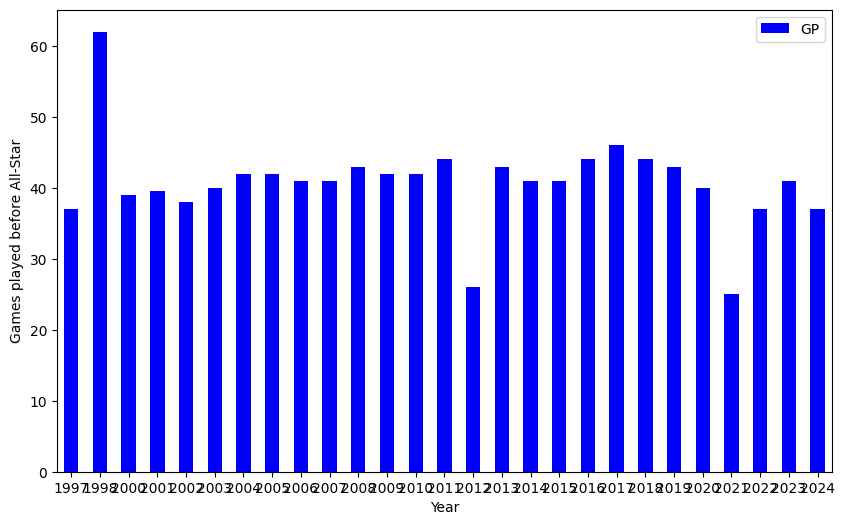

In [33]:
plt.rcParams['figure.figsize'] = (10, 6)
GP_pivot = nba.pivot_table(index='YEAR',
                  values='GP', aggfunc=np.median)
GP_pivot.plot(kind='bar', color='blue')
plt.xlabel('Year')
plt.ylabel('Games played before All-Star')
plt.xticks(rotation=0)
plt.show()

As seen, there seems to be a problem in the NBA Stats website for 1997-98 season as the data recorded is from the full season:

In [34]:
nba[nba['YEAR'] == 1998].head()

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
423,A.C. Green,DAL,34.0000,82,20,62,0.2440,32.3000,3.0000,6.5000,0.4530,0.0000,0.0000,0.0000,1.4000,2.0000,0.7160,2.7000,5.5000,8.1000,1.5000,0.8000,1.0000,0.3000,0.4000,1.9000,0.0000,7.3000,-4.6000,22.4000,14,0,19.5000,F,6-9,225.0000,Oregon State,USA,1985.0000,1.0000,23.0000,1985,1998,82.0000,20.0000,62.0000,0.2440,0.0000,W
424,Aaron McKie,PHI,25.0000,81,34,47,0.4200,22.4000,1.7000,4.7000,0.3650,0.1000,0.8000,0.1900,0.5000,0.7000,0.7640,0.7000,2.1000,2.9000,2.2000,0.9000,1.2000,0.2000,0.4000,2.0000,0.0000,4.1000,0.3000,14.0000,0,0,12.1000,G,6-5,209.0000,Temple,USA,1994.0000,1.0000,17.0000,1994,1998,82.0000,31.0000,51.0000,0.3780,0.0000,E
425,Aaron Williams,SEA,26.0000,65,49,16,0.7540,11.6000,1.8000,3.4000,0.5250,0.0000,0.0000,0.0000,1.0000,1.3000,0.7760,0.8000,1.5000,2.3000,0.2000,0.8000,0.3000,0.6000,0.4000,1.8000,0.0000,4.6000,1.0000,9.5000,0,0,8.8000,C-F,6-9,235.0000,Xavier,USA,0.0000,0.0000,0.0000,1993,1998,82.0000,61.0000,21.0000,0.7440,0.0000,W
426,Adam Keefe,UTA,28.0000,80,61,19,0.7630,25.6000,2.9000,5.3000,0.5400,0.0000,0.0000,0.0000,2.0000,2.5000,0.8100,2.2000,3.2000,5.5000,1.1000,0.9000,0.7000,0.3000,0.7000,2.2000,0.0000,7.8000,5.4000,18.0000,5,0,16.2000,F,6-9,230.0000,Stanford,USA,1992.0000,1.0000,10.0000,1992,1998,82.0000,62.0000,20.0000,0.7560,0.0000,W
427,Adonal Foyle,GSW,23.0000,55,9,46,0.1640,12.0000,1.3000,3.1000,0.4060,0.0000,0.0000,0.0000,0.5000,1.1000,0.4350,1.3000,2.0000,3.3000,0.3000,0.9000,0.2000,0.9000,0.3000,1.7000,0.0000,3.0000,-3.1000,10.0000,0,0,9.0000,C,6-10,270.0000,Colgate,St. Vincent & Grenadines,1997.0000,1.0000,8.0000,1997,1998,82.0000,19.0000,63.0000,0.2320,0.0000,W


Therefore we can remove the data from this year for our study:

In [35]:
nba = nba[nba['YEAR'] != 1998]
nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,WT,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
count,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000,11982.0000
mean,26.9565,34.5921,17.2475,17.3446,0.4887,20.0918,3.0576,6.8192,0.4336,0.6427,1.8351,0.2447,1.4613,1.9415,0.6911,0.9318,2.6178,3.5493,1.8206,1.1657,0.6320,0.4138,0.4158,1.8124,1.2578,8.2157,-0.2798,17.1661,2.8771,0.0863,16.3102,222.3222,1660.4050,1.0624,17.8145,2006.2811,2012.0114,51.7873,25.8065,25.9809,0.4983,0.0554
std,4.3409,16.4075,10.5527,9.8847,0.1932,10.2886,2.2639,4.7927,0.1124,0.7451,1.9533,0.1791,1.4384,1.8043,0.2208,0.8273,1.8516,2.5361,1.8286,0.8308,0.4521,0.4770,0.3266,0.8468,1.4143,6.2217,3.0343,11.2874,6.3380,0.7454,10.7758,27.3711,757.0858,0.6622,16.4896,8.9172,7.6984,6.0861,8.5930,8.6163,0.1547,0.2288
min,18.0000,1.0000,0.0000,0.0000,0.0000,0.1000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-25.0000,-2.3000,0.0000,0.0000,0.0000,133.0000,0.0000,0.0000,0.0000,1976.0000,1997.0000,30.0000,4.0000,4.0000,0.0770,0.0000
25%,24.0000,22.0000,9.0000,10.0000,0.3640,11.5000,1.3000,3.0000,0.3940,0.0000,0.1000,0.0000,0.5000,0.7000,0.6360,0.3000,1.3000,1.7000,0.6000,0.6000,0.3000,0.1000,0.2000,1.2000,0.1000,3.4000,-2.0000,8.2000,0.0000,0.0000,7.7000,201.0000,1994.0000,1.0000,3.0000,2000.0000,2006.0000,50.0000,19.0000,20.0000,0.3890,0.0000
50%,26.0000,39.0000,17.0000,17.0000,0.5000,19.7000,2.5000,5.6000,0.4380,0.4000,1.2000,0.3070,1.0000,1.4000,0.7500,0.7000,2.2000,3.0000,1.2000,1.0000,0.6000,0.3000,0.3000,1.8000,0.9000,6.6000,-0.5000,15.0000,0.0000,0.0000,14.2000,220.0000,2003.0000,1.0000,14.0000,2006.0000,2012.0000,53.0000,26.0000,25.0000,0.5080,0.0000
75%,30.0000,49.0000,25.0000,24.0000,0.6180,28.7000,4.4000,9.6000,0.4840,1.1000,3.0000,0.3700,2.0000,2.6000,0.8220,1.3000,3.5000,4.7000,2.4000,1.6000,0.9000,0.5000,0.6000,2.4000,1.9000,11.7000,1.4000,24.1000,2.0000,0.0000,23.0000,240.0000,2011.0000,1.0000,29.0000,2014.0000,2019.0000,55.0000,32.0000,32.0000,0.6080,0.0000
max,43.0000,61.0000,48.0000,48.0000,1.0000,44.0000,11.9000,27.5000,1.0000,5.1000,13.6000,1.0000,10.5000,13.0000,1.0000,6.6000,11.7000,16.5000,12.6000,5.8000,3.0000,4.3000,3.0000,5.0000,9.6000,36.6000,15.3000,62.4000,51.0000,27.0000,61.9000,330.0000,2023.0000,8.0000,165.0000,2023.0000,2024.0000,61.0000,48.0000,48.0000,0.9230,1.0000


It needs to be noted that the games played for 2012 and 2021 are also lower than usual since there was another lockout in the beginning of 2011-12 season which got resolved in December. And last season had to start in December as well due to Covid delaying the end of 2020 season. However in both cases the All-Star games were organized and players had about 25 games which is enough to evaluate. As a result, we will keep these 2 years in the dataset.

## Feature Engineering

From experience of following the league, we know that games played is used a filter to eliminate players from all-star contention. So we need a feature that describes how available a player was in the season:

In [36]:
nba['GP_PCT'] = nba['GP'] / nba['TEAM_GP']
nba['GP_PCT'].describe()

count   11982.0000
mean        0.6699
std         0.3082
min         0.0167
25%         0.4340
50%         0.7679
75%         0.9434
max         1.1333
Name: GP_PCT, dtype: float64

There are some players who get traded before or during the All-Star break to a new team. NBA Stats website lists the players' teams that they finish the season with. In the case of traded players, this results in a couple of percentage points more or less than the actual percentage of games played. This is not significant since team schedules usually only differ by 3-4 games:

In [37]:
nba[nba['YEAR'] == 2019]['TEAM_GP'].value_counts()

TEAM_GP
57.0000    201
58.0000    136
59.0000    134
56.0000     31
Name: count, dtype: int64

However, this results in some players having more than 100% games played, which can be rounded down to 100%:

In [38]:
nba.loc[nba['GP_PCT'] > 1, 'GP_PCT'] = 1
nba['GP_PCT'].describe()

count   11982.0000
mean        0.6698
std         0.3080
min         0.0167
25%         0.4340
50%         0.7679
75%         0.9434
max         1.0000
Name: GP_PCT, dtype: float64

Prior to 2017, the starting 5s in the all-star games were chosen purely by fan votes. This meant that some popular players got voted in despite not being deserving due to on-court performance. We can use the new availability feature to look for these outliers:

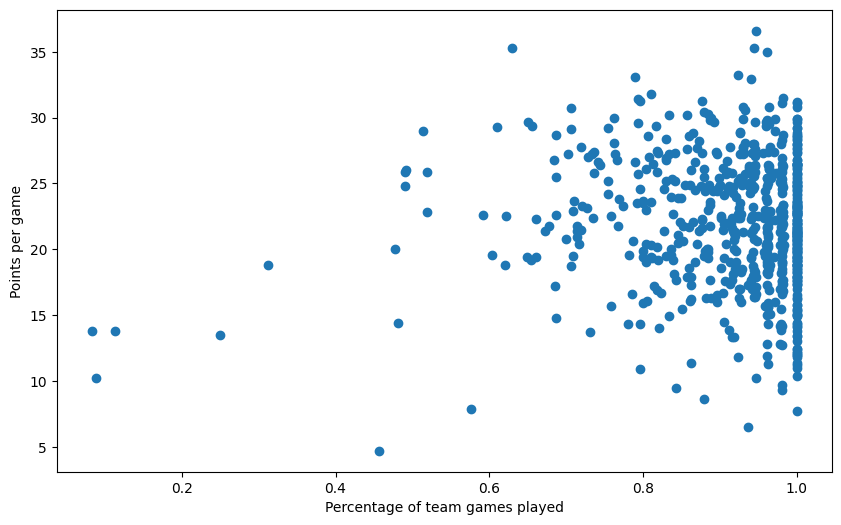

In [39]:
selected = nba[nba['ALLSTAR'] == 1]
plt.scatter(x=selected['GP_PCT'], y=selected['PTS'])
plt.ylabel('Points per game')
plt.xlabel('Percentage of team games played')
plt.show()

As seen, most all-stars played the majority of their team's games. Looking at the graph we can see there are 5 outliers to the left of the graph having played less than 40% of their team's games:

In [40]:
selected[selected['GP_PCT'] < 0.4]

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF,GP_PCT
1836,Grant Hill,ORL,28.0000,4,1,3,0.2500,33.1000,4.8000,10.8000,0.4420,0.3000,0.3000,1.0000,4.0000,6.5000,0.6150,2.0000,4.3000,6.3000,6.3000,2.8000,1.3000,0.5000,1.0000,2.3000,0.0000,13.8000,-7.3000,33.1000,0,0,30.0000,F,6-8,225.0000,Duke,USA,1994.0000,1.0000,3.0000,1994,2001,48.0000,25.0000,23.0000,0.5210,1.0000,E,0.0833
2916,Vince Carter,TOR,26.0000,15,8,7,0.5330,29.9000,7.5000,17.4000,0.4330,1.2000,3.8000,0.3160,2.5000,3.3000,0.7760,1.4000,2.1000,3.5000,2.5000,1.6000,0.9000,0.7000,0.5000,2.6000,0.0000,18.8000,1.4000,29.8000,1,0,29.1000,G-F,6-6,220.0000,North Carolina,USA,1998.0000,1.0000,5.0000,1998,2003,48.0000,14.0000,34.0000,0.2920,1.0000,E,0.3125
4634,Shaquille O'Neal,MIA,35.0000,13,8,5,0.6150,24.7000,5.7000,10.9000,0.5210,0.0000,0.0000,0.0000,2.1000,4.3000,0.4820,2.0000,3.8000,5.8000,1.2000,2.3000,0.3000,1.8000,0.5000,3.4000,4.2000,13.5000,2.7000,26.1000,1,0,24.6000,C,7-1,325.0000,Louisiana State,USA,1992.0000,1.0000,1.0000,1992,2007,52.0000,26.0000,26.0000,0.5000,1.0000,E,0.2500
6431,Yao Ming,HOU,30.0000,5,1,4,0.2000,18.1000,3.6000,7.4000,0.4860,0.0000,0.0000,0.0000,3.0000,3.2000,0.9380,1.4000,4.0000,5.4000,0.8000,1.4000,0.0000,1.6000,0.6000,2.6000,3.4000,10.2000,-5.4000,21.3000,0,0,19.6000,C,7-6,310.0000,Shanghai,China,2002.0000,1.0000,1.0000,2002,2011,57.0000,26.0000,31.0000,0.4560,1.0000,W,0.0877
7591,Kobe Bryant,LAL,35.0000,6,2,4,0.3330,29.5000,5.2000,12.2000,0.4250,0.5000,2.7000,0.1880,3.0000,3.5000,0.8570,0.3000,4.0000,4.3000,6.3000,5.7000,1.2000,0.2000,0.8000,1.5000,2.7000,13.8000,-5.3000,26.9000,0,0,27.7000,F-G,6-6,212.0000,Lower Merion HS (PA),USA,1996.0000,1.0000,13.0000,1996,2014,53.0000,18.0000,35.0000,0.3400,1.0000,W,0.1132


Injury forced all of these 5 superstars to miss those games, and 3 of them could not even participate in the all-star game. So we can remove these outliers that can affect our regression model:

In [41]:
nba.drop(nba.loc[(nba['ALLSTAR'] == 1) & (nba['GP_PCT'] < 0.4)].index, inplace=True)
nba.shape

(11977, 50)

The graph also reveals another player who has scored less than 5 points per game and played only about 45% of his team's games. That player turns out be Dirk Nowitzki, who together with Dwyane Wade got added to the roster in 2019 by the league to honor their careers, as they were both retiring. Since it wasn't a performance-based selection, these 2 outliers can be removed as well:

In [42]:
nba.drop(nba.loc[(nba['PLAYER_NAME'] == 'Dirk Nowitzki') & (nba['YEAR'] == 2019)].index, inplace=True)
nba.drop(nba.loc[(nba['PLAYER_NAME'] == 'Dwyane Wade') & (nba['YEAR'] == 2019)].index, inplace=True)
nba.shape

(11975, 50)

At this point, we can check how many all-stars are left in our data:

In [43]:
nba['ALLSTAR'].value_counts()

ALLSTAR
0.0000    11318
1.0000      657
Name: count, dtype: int64

As seen, there are about 16 times as many non all-stars than all-stars which is a called a class imbalance. This causes a major issue when we use accuracy as a metric as a classifier can predict 0 for every row, and still have high accuracy. 

At this point, we can use undersampling to filter out some of the non all-stars to aid the classifiers in making predictions. As we have done above with the all-stars, we can drop every player who appeared in less than 40 % of their teams' games:

In [44]:
nba.drop(nba.loc[nba['GP_PCT'] < 0.4].index, inplace=True)
nba['ALLSTAR'].value_counts()

ALLSTAR
0.0000    8572
1.0000     657
Name: count, dtype: int64

However, there are still many more non all-stars than all-stars. The next feature we can use to filter out non all-stars is the minutes played. If we check how many minutes the all-stars average:

In [45]:
nba[nba['ALLSTAR'] == 1]['MIN'].describe()

count   657.0000
mean     36.0373
std       2.9016
min      26.7000
25%      34.2000
50%      36.1000
75%      37.9000
max      44.0000
Name: MIN, dtype: float64

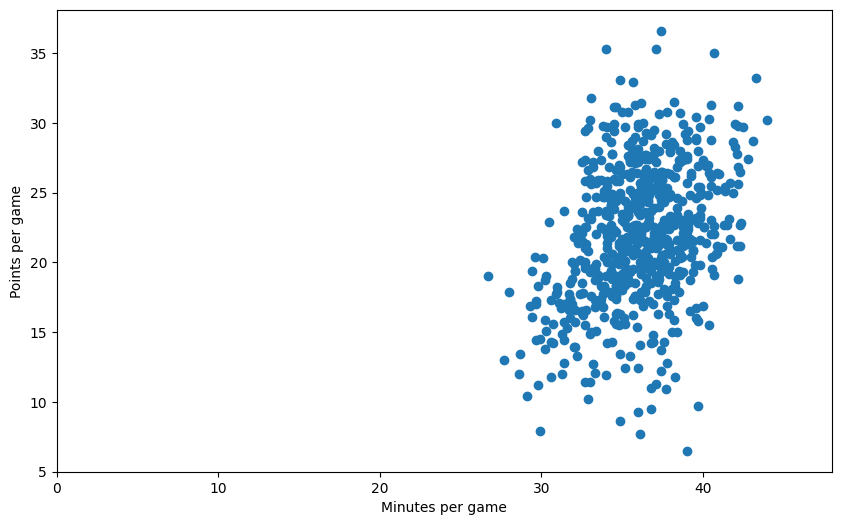

In [46]:
selected = nba[nba['ALLSTAR'] == 1]
plt.scatter(x=selected['MIN'], y=selected['PTS'])
plt.ylabel('Points per game')
plt.xlabel('Minutes per game')
plt.xlim(0,48)
plt.show()

We can see that none of the all-stars played less than 26 minutes per game. Therefore we can use 24 minutes (half of the duration of a full game) as the lower threshold for minutes played and drop every player below that:

In [47]:
nba.drop(nba.loc[nba['MIN'] < 24].index, inplace=True)
nba['ALLSTAR'].value_counts()

ALLSTAR
0.0000    3740
1.0000     657
Name: count, dtype: int64

As seen, we were able to reduce the imbalance to about 6 to 1 which should be manageable for the classifier.

Now if we look at some of our numeric columns, we can see a big difference between the range of each:

In [48]:
nba[['PTS', 'AST', 'W_PCT']].describe()

,PTS,AST,W_PCT
count,4397.0000,4397.0000,4397.0000
mean,14.3903,3.2215,0.5031
std,5.3930,2.1041,0.1552
min,3.1000,0.2000,0.0680
25%,10.4000,1.6000,0.3930
50%,13.3000,2.6000,0.5100
75%,17.7000,4.4000,0.6150
max,36.6000,12.6000,0.9440


In [49]:
nba.to_csv(os.path.join(output_data_dir, 'nba_allstar_processed_data.csv'),index=False)